In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Prohibited Comment Classification 



In [ ]:
import pandas as pd
data = pd.read_csv("comments.tsv", sep='\t')

texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [ ]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

In [ ]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "fuck you" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "fuck you" with "Ok, great!".
after: how to be a grown-up at work : replace " fuck you " with " ok , great ! " .


In [ ]:
# task: preprocess each comment in train and test

texts_train = [preprocess(x) for x in texts_train]
texts_test = [preprocess(x) for x in texts_test]

In [ ]:
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

Сделаем ещё и стемминг

In [ ]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
texts_test = [stemmer.stem(text) for text in texts_test]
texts_train = [stemmer.stem(text) for text in texts_train]

И уберем сайты, почты, числа и некоторую пунктуацию

In [ ]:
import re
texts_train = [re.sub(r'\b\S*\d+\S*\b',' ',text) for text in texts_train]
texts_train = [re.sub(r'\S*[@\]\[\\`{|}~»«—_]\S*',' ',text) for text in texts_train]
texts_train = [re.sub(r'\s+',' ',text) for text in texts_train]
texts_test = [re.sub(r'\b\S*\d+\S*\b',' ',text) for text in texts_test]
texts_test = [re.sub(r'\S*["#$%&\'()*+,-/<=>?@\]\[\\`{|}~»«—_]\S*',' ',text) for text in texts_test]
texts_test = [re.sub(r'\s+',' ',text) for text in texts_test]

In [ ]:
texts_train[0]

'... oh and what kind of person watches another persons mytalk page ? stalker !'

### Solving it: bag of words

![img](http://www.novuslight.com/uploads/n/BagofWords.jpg)




In [ ]:
# find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
from collections import Counter

k = 10000

bow_vocabulary = Counter(' '.join(texts_train).split()).most_common(k)
bow_vocabulary = [c[0] for c in bow_vocabulary]

print('example features:', sorted(bow_vocabulary)[::100])

example features: ['!', 'ad', 'alcohol', 'apparently', 'atricle', 'beating', 'blundering', 'business', 'chance', 'closely', 'conform', "couldn't", 'darkness', 'deserves', 'display', 'ears', 'enough', 'expertise', 'fictional', 'forth', 'gentlemen', 'guns', 'hercules', 'humor', 'independence', 'ip', 'keen', 'leave', 'lol', 'matches', 'miss', 'myspace', 'nonsense', 'one', 'party', 'piotrus', 'preferred', 'proviso', 'reactions', 'remember', 'revisions', 'satisfy', 'shade', 'skill', 'specified', 'strongly', 'swallow', 'than', "today's", 'twinkle', 'uppercase', 'vowel', 'whole', 'wront', 'வெளி']


In [ ]:
def text_to_bow(text):
    res = np.zeros(len(bow_vocabulary))
    for word in text.split(' '):
      if word in bow_vocabulary:
        res[bow_vocabulary.index(word)] += 1
    return np.array(res, 'float32')

In [ ]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

In [ ]:
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Machine learning stuff: fit, predict, evaluate. 

In [ ]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

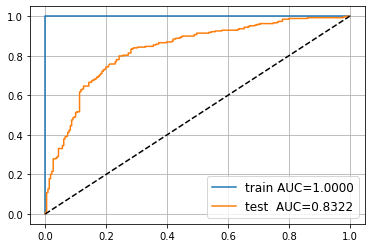

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()



### Solving it better: word vectors

Let's try another approach: instead of counting per-word frequencies, we shall map all words to pre-trained word vectors and average over them to get text features.

This should give us two key advantages: (1) we now have 10^2 features instead of 10^4 and (2) our model can generalize to word that are not in training dataset.

We begin with a standard approach with pre-trained word vectors. However, you may also try
* training embeddings from scratch on relevant (unlabeled) data
* multiplying word vectors by inverse word frequency in dataset (like tf-idf).
* concatenating several embeddings
    * call `gensim.downloader.info()['models'].keys()` to get a list of available models
* clusterizing words by their word-vectors and try bag of cluster_ids


In [ ]:
import gensim.downloader 
embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")
.

[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
def vectorize_sum(comment):
    """
    implement a function that converts preprocessed comment to a sum of token vectors
    """
    embedding_dim = embeddings.wv.vectors.shape[1]
    features = np.zeros([embedding_dim], dtype='float32')
    
    for word in comment.split(' '):
      if word in embeddings:
        features += embeddings[word]
    
    return features

assert np.allclose(
    vectorize_sum("who cares anymore . they attack with impunity .")[::70],
    np.array([ 0.0108616 ,  0.0261663 ,  0.13855131, -0.18510573, -0.46380025])
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


In [ ]:
X_train_wv = np.stack([vectorize_sum(text) for text in texts_train])
X_test_wv = np.stack([vectorize_sum(text) for text in texts_test])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


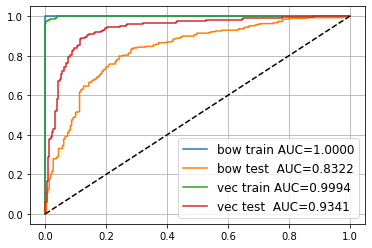

In [ ]:
wv_model = LogisticRegression().fit(X_train_wv, y_train)

for name, X, y, model in [
    ('bow train', X_train_bow, y_train, bow_model),
    ('bow test ', X_test_bow, y_test, bow_model),
    ('vec train', X_train_wv, y_train, wv_model),
    ('vec test ', X_test_wv, y_test, wv_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

assert roc_auc_score(y_test, wv_model.predict_proba(X_test_wv)[:, 1]) > 0.92, "something's wrong with your features"

We just managed to reduce misclassification rate by a factor of two.
This trick is very useful when we're dealing with small datasets. However, if you have hundreds of thousands of samples, there's a whole different range of methods for that. We'll get there in the second part.

# Natural Language Processing with Deep Learning 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [ ]:
!unzip -n Train_rev1.zip

Archive:  Train_rev1.zip
  inflating: Train_rev1.csv          


In [ ]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
96222,69248935,Year 2 Teacher,Year 2 Teacher Central London ASAP An Good P...,North London,North London,full_time,contract,HORIZON TEACHERS,Teaching Jobs,135 - 155 per day,34800,jobs.guardian.co.uk,10.457401
111129,69683424,Service Desk Analyst,Urgent requirement for a Service Desk Analyst ...,Leeds,Leeds,NaN,contract,NaN,Other/General Jobs,10.00 - 13.00 per hour,22080,hays.co.uk,10.002473
43708,68503547,Research Fellow in Molecular Microbiology SB****,(Ref: ****) The School of Medicine wishes to a...,Scotland,Scotland,NaN,NaN,University of St Andrews,Teaching Jobs,"30,424 to 36,298",33361,Jobs Ac,10.415173


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [ ]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [ ]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [ ]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [ ]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
token_counts.update(Counter(' '.join(data['Title']).split(' ')))
token_counts.update(Counter(' '.join(data['FullDescription']).split(' ')))

In [ ]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

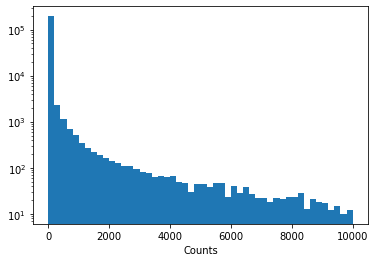

In [ ]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

Get a list of all tokens that occur at least 10 times.

In [ ]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token,value in token_counts.items() if value >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [ ]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [ ]:
token_to_id = dict(zip(tokens,range(0,len(tokens))))

In [ ]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [ ]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [ ]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [ ]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.



In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [ ]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [ ]:
generate_batch(data_train, 3, max_len=10)

{'Title': array([[  94,   88,    1,    1,    1,    1,    1],
        [ 497,   43,    1,    1,    1,    1,    1],
        [ 992,   97,   63,   58,   64, 2052,  671]], dtype=int32),
 'FullDescription': array([[ 8830,  1314,  2241,  2497,    49,  4820,    55,   142,  1497,
            73],
        [ 8830,  1314,  1464,   560,   561,  3451,    15, 13116,     9,
          1597],
        [12427,   992,    97,    63,  2052,  1609,  1499,    64,  1314,
          1166]], dtype=int32),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([10.768506, 10.165891,  9.615872], dtype=float32)}

### Deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [ ]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = nn.ReLU()(h)
        h = self.dense(h)
        
        return h

In [ ]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


Create description encoder

In [ ]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense1 = nn.Linear(out_size, out_size)
        self.dense2 = nn.Linear(out_size, out_size)


    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = nn.ReLU()(h)
        h = self.dense1(h)
        h = nn.ReLU()(h)
        h = self.dense2(h)
        return h

In [ ]:
desc_encoder = DescriptionEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


Build one network

In [ ]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.dense_cat_1 = nn.Linear(n_cat_features, n_cat_features)
        self.dense_cat_2 = nn.Linear(n_cat_features, n_cat_features)
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.dense_output_1 = nn.Linear(3896, 500)
        self.dense_output_2 = nn.Linear(500, 1)
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.dense_cat_1(cat_features)
        cat_h = nn.ReLU()(cat_h)
        cat_h = self.dense_cat_2(cat_h)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        joint_h = self.dense_output_1(joint_h)
        joint_h = nn.ReLU()(joint_h)
        output = self.dense_output_2(joint_h)

        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return output[:, 0]

In [ ]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [ ]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [ ]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it

In [ ]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [ ]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [ ]:
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.numpy()
            val_mae += compute_mae(reference, prediction).data.numpy()
            val_batches += 1
    

    print("Epoch:\t%s" % (epoch_i))
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

In [ ]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13374
	MAE:	3656.45773





### Actually make it work


#### A) CNN architecture

* Dropout. 
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

  * Use early stopping. .
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### CNN + pre-trained word2vec+ early stopping

In [ ]:
import gensim
import gensim.downloader
word2vec_gensim = gensim.downloader.load('word2vec-google-news-300')

[=======================================-----------] 78.9% 1311.1/1662.8MB downloaded

KeyboardInterrupt: ignored

In [ ]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.norm_conv1 = nn.BatchNorm1d(out_size)
        self.pool1 = GlobalMaxPooling()        
        self.dense1 = nn.Linear(out_size, out_size)
        self.dense2 = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.norm_conv1(h)
        h = nn.ReLU()(h)
        h = self.pool1(h)
        h = nn.ReLU()(h)
        h = self.dense1(h)
        h = nn.ReLU()(h)
        h = nn.Dropout(p=0.2)(h)
        h = self.dense2(h)
        return h

In [ ]:
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.norm_conv1 = nn.BatchNorm1d(out_size)
        self.pool1 = GlobalMaxPooling()        
        self.dense1 = nn.Linear(out_size, out_size)
        self.dense2 = nn.Linear(out_size, out_size)
        self.dense3 = nn.Linear(out_size, out_size)


    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.norm_conv1(h)
        h = nn.ReLU()(h)
        h = self.pool1(h)
        h = nn.ReLU()(h)
        h = self.dense1(h)
        h = nn.ReLU()(h)
        h = nn.Dropout(p=0.2)(h)
        h = self.dense2(h)
        h = nn.ReLU()(h)
        h = nn.Dropout(p=0.2)(h)
        h = self.dense3(h)
        return h

In [ ]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.dense_cat_1 = nn.Linear(n_cat_features, n_cat_features)
        self.dense_cat_2 = nn.Linear(n_cat_features, n_cat_features)
        
        # define "output" layers that process depend the three encoded vectors into answer

        self.conv1_out = nn.Conv1d(3896, 1024, kernel_size=3, padding=1)
        self.norm_conv1_out = nn.BatchNorm1d(1024)
        self.pool1_out = GlobalMaxPooling()
        self.dense_out_1 = nn.Linear(1024, 512)
        self.dense_out_2 = nn.Linear(512, 512)
        self.dense_out_3 = nn.Linear(512, 1)
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.dense_cat_1(cat_features)
        cat_h = nn.ReLU()(cat_h)
        cat_h = self.dense_cat_2(cat_h)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        joint_h = self.conv1_out(joint_h)
        joint_h = self.norm_conv1_out(joint_h)
        joint_h = nn.ReLU()(joint_h)
        joint_h = self.pool1_out(joint_h)
        joint_h = self.dense_out_1(joint_h)
        joint_h = nn.ReLU()(joint_h)
        joint_h = nn.Dropout(p=0.2)(joint_h)
        joint_h = self.dense_out_2(joint_h)
        joint_h = nn.ReLU()(joint_h)
        joint_h = nn.Dropout(p=0.2)(joint_h)
        output = self.dense_out_3(joint_h)

        return output[:, 0]

In [ ]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [ ]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [ ]:
for epoch_i in range(num_epochs):

    print("Epoch:\t%s" % (epoch_i))
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.numpy()
            val_mae += compute_mae(reference, prediction).data.numpy()
            val_batches += 1
    

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

    check_early_stopping((val_mae / val_batches),(train_mae / train_batches))
    if check_early_stopping.early_stop:
      print('Early stopping indicator')
      break

Training:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.23140
	MAE:	4764.87889



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch:	0
	Loss:	0.19087
	MAE:	4245.00965



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.22337
	MAE:	4548.27617



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch:	1
	Loss:	0.18442
	MAE:	3958.39976



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.19505
	MAE:	4283.17959



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch:	2
	Loss:	0.25003
	MAE:	5613.66173



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18936
	MAE:	4165.63046



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch:	3
	Loss:	0.17065
	MAE:	3692.58491



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.17658
	MAE:	4039.99972



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch:	4
	Loss:	0.15878
	MAE:	3772.13117



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18721
	MAE:	4095.94250



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch:	5
	Loss:	0.17564
	MAE:	3727.32127



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18106
	MAE:	4116.47059



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch:	6
	Loss:	0.14826
	MAE:	3539.99100



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.16592
	MAE:	3926.57032



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch:	7
	Loss:	0.22656
	MAE:	5540.29442



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18284
	MAE:	4120.36240



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch:	8
	Loss:	0.16372
	MAE:	3613.15801



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15224
	MAE:	3725.23287



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch:	9
	Loss:	0.13842
	MAE:	3493.53428



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.16683
	MAE:	3918.86226



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch:	10
	Loss:	0.19929
	MAE:	4849.65294



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.17643
	MAE:	4066.12545



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch:	11
	Loss:	0.13518
	MAE:	3442.09150



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14458
	MAE:	3656.59429



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch:	12
	Loss:	0.14151
	MAE:	3410.16327



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18669
	MAE:	4290.02945



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch:	13
	Loss:	0.13452
	MAE:	3544.09424



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.17125
	MAE:	4032.48074



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch:	14
	Loss:	0.13382
	MAE:	3554.45894



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13759
	MAE:	3589.31971



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch:	15
	Loss:	0.15070
	MAE:	4044.80000



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.17436
	MAE:	4131.04408



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch:	16
	Loss:	0.13884
	MAE:	3397.32120



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14492
	MAE:	3714.94597



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch:	17
	Loss:	0.14788
	MAE:	4001.68064



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13141
	MAE:	3552.14726



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch:	18
	Loss:	0.11940
	MAE:	3288.44257



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12869
	MAE:	3499.43585



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch:	19
	Loss:	0.11790
	MAE:	3275.06681



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13374
	MAE:	3656.45773



